In [1]:
import os
import tifffile
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

class UNetDataset3to11(Dataset):
    def __init__(self, image_files, image_dir, mask_dir, target_size=(128,128), augment=False):
        self.image_files = image_files
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.target_size = target_size
        self.augment = augment

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        mask_file = img_file.replace(".tif", ".png")

        # --- Load image ---
        img = tifffile.imread(os.path.join(self.image_dir, img_file)).astype(np.float32)

        # Ensure 12 channels
        if img.ndim == 2:
            img = np.stack([img]*12, axis=-1)
        elif img.ndim == 3 and img.shape[-1] < 12:
            pad_width = 12 - img.shape[-1]
            img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
        elif img.ndim == 3 and img.shape[-1] > 12:
            img = img[..., :12]

        # --- Keep channels 3→11 ---
        img = img[..., 3:]  # shape (H,W,9)

        # --- Normalize per channel ---
        img_max = np.max(img, axis=(0,1), keepdims=True)
        img_max[img_max==0] = 1
        img = img / img_max

        # --- Resize channels individually ---
        img_resized = []
        for ch in range(img.shape[-1]):
            ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))
            ch_img = ch_img.resize(self.target_size, Image.Resampling.BILINEAR)
            img_resized.append(np.array(ch_img, dtype=np.float32)/255.0)
        img = np.stack(img_resized, axis=-1)  # (H,W,9)

        # --- Load mask (untouched, no normalization) ---
        mask = Image.open(os.path.join(self.mask_dir, mask_file)).convert("L")
        mask = mask.resize(self.target_size, Image.Resampling.NEAREST)
        mask = np.expand_dims(np.array(mask, dtype=np.int64), axis=-1)  # (H,W,1)

        # --- Optional augmentation ---
        if self.augment:
            if np.random.rand() > 0.5:
                img = np.flip(img, axis=1)
                mask = np.flip(mask, axis=1)
            if np.random.rand() > 0.5:
                img = np.flip(img, axis=0)
                mask = np.flip(mask, axis=0)

        # Convert to torch tensors
        img_tensor = torch.from_numpy(img.transpose(2,0,1)).float()  # (C,H,W)
        mask_tensor = torch.from_numpy(mask.squeeze(-1)).long()       # (H,W)

        return img_tensor, mask_tensor

In [2]:
image_dir = r"D:\cellula\task_2\data\images"
mask_dir  = r"D:\cellula\task_2\data\labels"
all_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])

split = int(0.8 * len(all_files))
train_files = all_files[:split]
val_files   = all_files[split:]

train_dataset = UNetDataset3to11(train_files, image_dir, mask_dir, augment=True)
val_dataset   = UNetDataset3to11(val_files, image_dir, mask_dir, augment=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [3]:
import torch.nn as nn
from torchvision.models.segmentation import fcn_resnet50

# Load pretrained segmentation backbone
model = fcn_resnet50(pretrained=True)

# Modify input layer to 9 channels instead of 3
orig_conv = model.backbone.conv1
model.backbone.conv1 = nn.Conv2d(
    in_channels=9,  # our 9-channel input
    out_channels=orig_conv.out_channels,
    kernel_size=orig_conv.kernel_size,
    stride=orig_conv.stride,
    padding=orig_conv.padding,
    bias=False
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


d:\anconda\envs\cellula_conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anconda\envs\cellula_conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_prediction_3to11(img, mask, pred, channels_to_rgb=[0,2,5], threshold=0.5):
    """
    img: numpy array of shape (H, W, 9)  (channels 3→11)
    mask: numpy array of shape (H, W) or (H, W, 1)
    pred: numpy array of shape (H, W, 1) or (H, W)
    channels_to_rgb: which 3 channels of img (0-8) to display as RGB
    threshold: threshold to binarize prediction
    """
    # Binarize prediction if needed
    if pred.ndim == 3 and pred.shape[-1] == 1:
        pred_binary = (pred[...,0] > threshold).astype(np.float32)
    else:
        pred_binary = pred

    # Prepare RGB image from selected channels
    if img.shape[-1] >= 3:
        rgb_img = img[..., channels_to_rgb]
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-8)
    else:
        rgb_img = img[..., 0]

    plt.figure(figsize=(12,4))

    # Input image
    plt.subplot(1,3,1)
    plt.imshow(rgb_img)
    plt.title(f"Input Image (channels 3→11, selected {channels_to_rgb})")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(1,3,2)
    if mask.ndim == 3:
        plt.imshow(mask[...,0], cmap='gray')
    else:
        plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Predicted mask
    plt.subplot(1,3,3)
    plt.imshow(pred_binary, cmap='gray')
    plt.title(f"Predicted Mask (threshold={threshold})")
    plt.axis("off")

    plt.show()


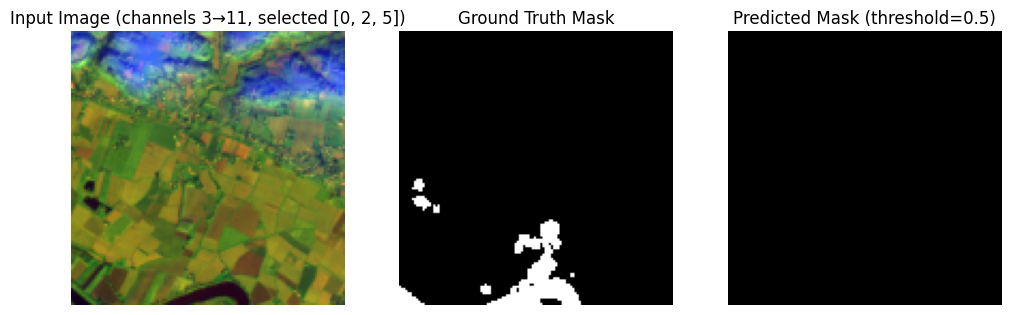

In [5]:
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)        # (B,9,H,W)
        masks = masks.to(device)      # (B,H,W)
        
        outputs = model(imgs)['out']  # (B,num_classes,H,W)
        preds = torch.argmax(outputs, dim=1)  # (B,H,W)

        # visualize first sample
        pred_mask = preds[3].cpu().numpy()
        true_mask = masks[3].cpu().numpy()
        img_np = imgs[3].cpu().numpy().transpose(1,2,0)  # (H,W,9)

        visualize_prediction_3to11(img_np, true_mask, pred_mask[...,None], channels_to_rgb=[0,2,5], threshold=0.5)
        break


            finetune the pretrain model 
             

In [6]:


import os
import tifffile
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class UNetDataset3to11(Dataset):
    def __init__(self, image_files, image_dir, mask_dir, target_size=(128,128), augment=False):
        self.image_files = image_files
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.target_size = target_size
        self.augment = augment

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        mask_file = img_file.replace(".tif", ".png")

        # --- Load image ---
        img = tifffile.imread(os.path.join(self.image_dir, img_file)).astype(np.float32)

        # Ensure 12 channels
        if img.ndim == 2:
            img = np.stack([img]*12, axis=-1)
        elif img.ndim == 3 and img.shape[-1] < 12:
            pad_width = 12 - img.shape[-1]
            img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
        elif img.ndim == 3 and img.shape[-1] > 12:
            img = img[..., :12]

        # --- Keep channels 3→11 ---
        img = img[..., 3:]  # shape (H,W,9)

        # --- Normalize per channel ---
        img_max = np.max(img, axis=(0,1), keepdims=True)
        img_max[img_max==0] = 1
        img = img / img_max

        # --- Resize channels individually ---
        img_resized = []
        for ch in range(img.shape[-1]):
            ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))
            ch_img = ch_img.resize(self.target_size, Image.Resampling.BILINEAR)
            img_resized.append(np.array(ch_img, dtype=np.float32)/255.0)
        img = np.stack(img_resized, axis=-1)  # (H,W,9)

        # --- Load mask (untouched, no normalization) ---
        mask = Image.open(os.path.join(self.mask_dir, mask_file)).convert("L")
        mask = mask.resize(self.target_size, Image.Resampling.NEAREST)
        mask = np.expand_dims(np.array(mask, dtype=np.int64), axis=-1)  # (H,W,1)

        # --- Optional augmentation ---
        if self.augment:
            if np.random.rand() > 0.5:
                img = np.flip(img, axis=1).copy()
                mask = np.flip(mask, axis=1).copy()
            if np.random.rand() > 0.5:
                img = np.flip(img, axis=0).copy()
                mask = np.flip(mask, axis=0).copy()

        # --- Convert to torch tensors (ensure contiguous memory) ---
        img_tensor = torch.from_numpy(np.ascontiguousarray(img.transpose(2,0,1))).float()  # (C,H,W)
        mask_tensor = torch.from_numpy(np.ascontiguousarray(mask.squeeze(-1))).long()       # (H,W)

        return img_tensor, mask_tensor

   

In [7]:
from torch.utils.data import DataLoader

train_dataset = UNetDataset3to11(train_files, image_dir, mask_dir, augment=True)
val_dataset   = UNetDataset3to11(val_files, image_dir, mask_dir, augment=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [8]:
from torch.utils.data import DataLoader

# Paths
image_dir = r"D:\cellula\task_2\data\images"
mask_dir  = r"D:\cellula\task_2\data\labels"
all_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])

split = int(0.8 * len(all_files))
train_files = all_files[:split]
val_files   = all_files[split:]

# Datasets and loaders
train_dataset = UNetDataset3to11(train_files, image_dir, mask_dir, augment=True)
val_dataset   = UNetDataset3to11(val_files, image_dir, mask_dir, augment=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Test batch
for imgs, masks in train_loader:
    print(imgs.shape, masks.shape)  # (B,9,H,W), (B,H,W)
    break


torch.Size([4, 9, 128, 128]) torch.Size([4, 128, 128])


In [9]:
import torch.nn as nn
from torchvision.models.segmentation import fcn_resnet50

# Load pretrained backbone
model = fcn_resnet50(pretrained=True)

# Change first conv layer to accept 9-channel input
orig_conv = model.backbone.conv1
model.backbone.conv1 = nn.Conv2d(
    in_channels=9,
    out_channels=orig_conv.out_channels,
    kernel_size=orig_conv.kernel_size,
    stride=orig_conv.stride,
    padding=orig_conv.padding,
    bias=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


d:\anconda\envs\cellula_conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anconda\envs\cellula_conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
import torch

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [16]:
num_epochs = 17

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)        # (B, 9, H, W)
        masks = masks.to(device)      # (B, H, W)

        optimizer.zero_grad()
        outputs = model(imgs)['out']  # (B, num_classes, H, W)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/17, Train Loss: 0.2454, Val Loss: 0.2301
Epoch 2/17, Train Loss: 0.2340, Val Loss: 0.2270
Epoch 3/17, Train Loss: 0.2215, Val Loss: 0.2038
Epoch 4/17, Train Loss: 0.2026, Val Loss: 0.2197
Epoch 5/17, Train Loss: 0.1925, Val Loss: 0.2267
Epoch 6/17, Train Loss: 0.2086, Val Loss: 0.2134
Epoch 7/17, Train Loss: 0.1963, Val Loss: 0.2255
Epoch 8/17, Train Loss: 0.1903, Val Loss: 0.2178
Epoch 9/17, Train Loss: 0.2120, Val Loss: 0.2257
Epoch 10/17, Train Loss: 0.2308, Val Loss: 0.2201
Epoch 11/17, Train Loss: 0.1961, Val Loss: 0.1970
Epoch 12/17, Train Loss: 0.1741, Val Loss: 0.2037
Epoch 13/17, Train Loss: 0.1605, Val Loss: 0.1878
Epoch 14/17, Train Loss: 0.1627, Val Loss: 0.1946
Epoch 15/17, Train Loss: 0.1532, Val Loss: 0.1942
Epoch 16/17, Train Loss: 0.1577, Val Loss: 0.1959
Epoch 17/17, Train Loss: 0.2002, Val Loss: 0.1939


In [17]:
# ----------------------------
def visualize_prediction_3to11(img, mask, pred, channels_to_rgb=[0,2,5], threshold=0.5):
    pred_binary = (pred[...,0] > threshold).astype(np.float32) if pred.ndim==3 else pred
    rgb_img = img[..., channels_to_rgb]
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max()-rgb_img.min()+1e-8)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(rgb_img); plt.title("Input Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask[...,0] if mask.ndim==3 else mask, cmap='gray'); plt.title("GT Mask"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(pred_binary, cmap='gray'); plt.title("Pred Mask"); plt.axis("off")
    plt.show()

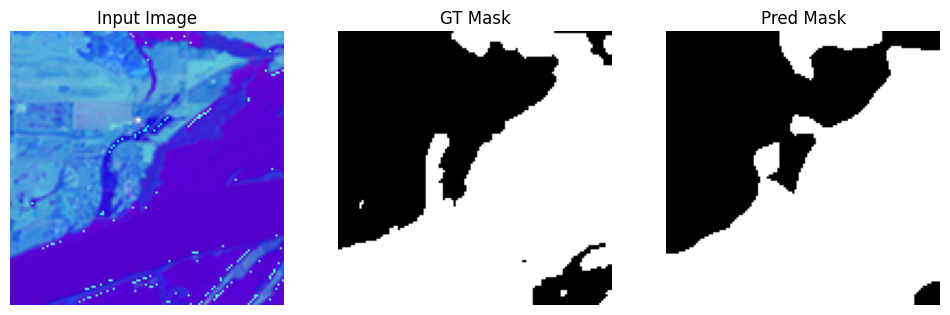

In [18]:
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = model(imgs)['out']
        preds = torch.argmax(outputs, dim=1)  # (B,H,W)

        # visualize first sample
        import numpy as np
        img_np = imgs[0].cpu().numpy().transpose(1,2,0)  # (H,W,9)
        true_mask = masks[0].cpu().numpy()
        pred_mask = preds[0].cpu().numpy()

        visualize_prediction_3to11(img_np, true_mask, pred_mask[...,None], channels_to_rgb=[0,2,5], threshold=0.5)
        break


#### new image visualization


In [19]:
import os
import numpy as np
from PIL import Image
import tifffile
import torch
import matplotlib.pyplot as plt

def visualize_prediction_auto(model, img_path, mask_dir=None, target_size=(128,128), channels_to_rgb=[0,2,5], threshold=0.5, device='cuda'):
    """
    Automatic preprocessing, prediction, and visualization for a new image.
    
    model     : PyTorch segmentation model
    img_path  : path to new image (.tif)
    mask_dir  : directory containing masks (optional)
    target_size : resize shape
    channels_to_rgb : which 3 channels to display
    threshold : threshold to binarize prediction
    device    : 'cuda' or 'cpu'
    """
    
    # --- Load and preprocess image ---
    img = tifffile.imread(img_path).astype(np.float32)
    if img.ndim == 2:
        img = np.stack([img]*12, axis=-1)
    elif img.ndim == 3 and img.shape[-1] < 12:
        pad_width = 12 - img.shape[-1]
        img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
    elif img.ndim == 3 and img.shape[-1] > 12:
        img = img[..., :12]
    
    img = img[..., 3:]  # channels 3→11

    # Normalize per channel
    img_max = np.max(img, axis=(0,1), keepdims=True)
    img_max[img_max==0] = 1
    img = img / img_max

    # Resize channels
    img_resized = []
    for ch in range(img.shape[-1]):
        ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))
        ch_img = ch_img.resize(target_size, Image.Resampling.BILINEAR)
        img_resized.append(np.array(ch_img, dtype=np.float32)/255.0)
    img = np.stack(img_resized, axis=-1)
    
    # Convert to tensor
    img_tensor = torch.from_numpy(img.transpose(2,0,1)).unsqueeze(0).float().to(device)

    # --- Predict ---
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)['out']
        pred_mask = torch.argmax(output, dim=1)[0].cpu().numpy()  # (H,W)
    
    # --- Load mask if available ---
    mask = None
    if mask_dir is not None:
        mask_name = os.path.basename(img_path).replace('.tif', '.png')
        mask_path = os.path.join(mask_dir, mask_name)
        if os.path.exists(mask_path):
            mask = np.array(Image.open(mask_path).resize(target_size, Image.Resampling.NEAREST))
            mask = np.expand_dims(mask, axis=-1)

    # --- Visualization ---
    pred_binary = (pred_mask > threshold).astype(np.float32)
    rgb_img = img[..., channels_to_rgb]
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(rgb_img)
    plt.title(f"Input Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    if mask is not None:
        plt.imshow(mask[...,0] if mask.ndim==3 else mask, cmap='gray')
        plt.title("Ground Truth Mask")
    else:
        plt.imshow(np.zeros_like(pred_binary), cmap='gray')
        plt.title("No GT Mask Found")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_binary, cmap='gray')
    plt.title(f"Predicted Mask (threshold={threshold})")
    plt.axis("off")

    plt.show()


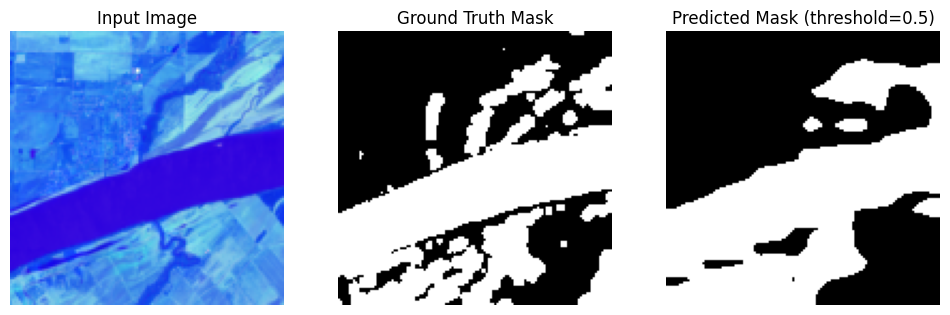

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_path = r"D:\cellula\task_2\data\images\18.tif"
mask_dir = r"D:\cellula\task_2\data\labels"  # optional, can be None

visualize_prediction_auto(model, img_path, mask_dir=mask_dir, channels_to_rgb=[0,2,5], device=device)


# Save only weights
torch.save(model.state_dict(), "segmentation_model_3to11.pth")

# OR save the whole model (structure + weights) [larger file but easier reload]
torch.save(model, "segmentation_model_3to11_full.pth")

In [34]:
torch.save(model.state_dict(), "segmentation_model_3to11.pth")

In [35]:
# Load the trained weights
model.load_state_dict(torch.load("segmentation_model_3to11.pth"))

model.eval()  # set to evaluation mode

C:\Users\Alieldin\AppData\Local\Temp\ipykernel_20292\50318436.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("segmentation_model_3to11.

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
import os
import numpy as np
from PIL import Image
import tifffile
import torch
import matplotlib.pyplot as plt

def visualize_prediction_auto(model, img_path, mask_dir=None, target_size=(128,128), channels_to_rgb=[0,2,5], threshold=0.5, device='cuda'):
    """
    Automatic preprocessing, prediction, and visualization for a new image.
    
    model     : PyTorch segmentation model
    img_path  : path to new image (.tif)
    mask_dir  : directory containing masks (optional)
    target_size : resize shape
    channels_to_rgb : which 3 channels to display
    threshold : threshold to binarize prediction
    device    : 'cuda' or 'cpu'
    """
    
    # --- Load and preprocess image ---
    img = tifffile.imread(img_path).astype(np.float32)
    if img.ndim == 2:
        img = np.stack([img]*12, axis=-1)
    elif img.ndim == 3 and img.shape[-1] < 12:
        pad_width = 12 - img.shape[-1]
        img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
    elif img.ndim == 3 and img.shape[-1] > 12:
        img = img[..., :12]
    
    img = img[..., 3:]  # channels 3→11

    # Normalize per channel
    img_max = np.max(img, axis=(0,1), keepdims=True)
    img_max[img_max==0] = 1
    img = img / img_max

    # Resize channels
    img_resized = []
    for ch in range(img.shape[-1]):
        ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))
        ch_img = ch_img.resize(target_size, Image.Resampling.BILINEAR)
        img_resized.append(np.array(ch_img, dtype=np.float32)/255.0)
    img = np.stack(img_resized, axis=-1)
    
    # Convert to tensor
    img_tensor = torch.from_numpy(img.transpose(2,0,1)).unsqueeze(0).float().to(device)

    # --- Predict ---
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)['out']
        pred_mask = torch.argmax(output, dim=1)[0].cpu().numpy()  # (H,W)
    
    # --- Load mask if available ---
    mask = None
    if mask_dir is not None:
        mask_name = os.path.basename(img_path).replace('.tif', '.png')
        mask_path = os.path.join(mask_dir, mask_name)
        if os.path.exists(mask_path):
            mask = np.array(Image.open(mask_path).resize(target_size, Image.Resampling.NEAREST))
            mask = np.expand_dims(mask, axis=-1)

    # --- Visualization ---
    pred_binary = (pred_mask > threshold).astype(np.float32)
    rgb_img = img[..., channels_to_rgb]
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(rgb_img)
    plt.title(f"Input Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    if mask is not None:
        plt.imshow(mask[...,0] if mask.ndim==3 else mask, cmap='gray')
        plt.title("Ground Truth Mask")
    else:
        plt.imshow(np.zeros_like(pred_binary), cmap='gray')
        plt.title("No GT Mask Found")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_binary, cmap='gray')
    plt.title(f"Predicted Mask (threshold={threshold})")
    plt.axis("off")

    plt.show()


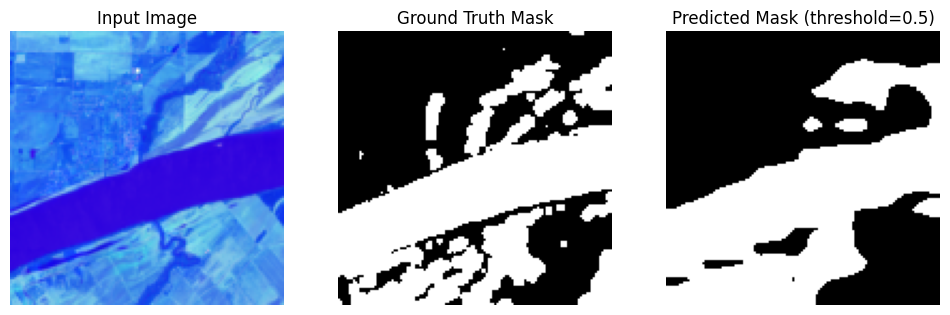

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_path = r"D:\cellula\task_2\data\images\18.tif"
mask_dir = r"D:\cellula\task_2\data\labels"  # optional, can be None

visualize_prediction_auto(model, img_path, mask_dir=mask_dir, channels_to_rgb=[0,2,5], device=device)